In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import gdown
import os

file_id = "18zvmgkm-T_PT8L-bSntddZhCVUZcMlNO"
out_path = "vp_cifar_ema_weights.pth"

if not os.path.exists(out_path):
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        out_path,
        quiet=False,
    )
else:
    print("EMA weights already downloaded.")


Downloading...
From (original): https://drive.google.com/uc?id=18zvmgkm-T_PT8L-bSntddZhCVUZcMlNO
From (redirected): https://drive.google.com/uc?id=18zvmgkm-T_PT8L-bSntddZhCVUZcMlNO&confirm=t&uuid=0a37150c-a4cf-4c7b-9909-743d663d2621
To: /home/onyxia/work/vp_cifar_ema_weights.pth
100%|██████████| 137M/137M [00:01<00:00, 96.5MB/s] 


In [5]:
import torch
import math

class VPSDE:
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T

    def beta(self, t):
        # t in [0,1], shape [B]
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def int_beta(self, t):
        # ∫0^t beta(s) ds for linear beta
        return self.beta_min * t + 0.5 * (self.beta_max - self.beta_min) * t**2

    def alpha(self, t):
        # alpha(t) = exp(-1/2 ∫ beta)
        return torch.exp(-0.5 * self.int_beta(t))

    def sigma(self, t):
        # sigma(t) = sqrt(1 - alpha(t)^2)
        a = self.alpha(t)
        return torch.sqrt(1.0 - a*a).clamp(min=1e-5)

    def diffusion(self, t):
        # g(t) = sqrt(beta(t))
        return torch.sqrt(self.beta(t)).clamp(min=1e-5)

    def drift(self, x, t):
        # f(x,t) = -1/2 beta(t) x
        b = self.beta(t).view(-1, 1, 1, 1)
        return -0.5 * b * x


In [6]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.dim = dim
        self.lin = nn.Linear(dim, dim)

    def forward(self, t):
        # t: [B]
        half_dim = self.dim // 2
        freqs = torch.exp(
            torch.arange(half_dim, device=t.device, dtype=t.dtype)
            * -(torch.log(torch.tensor(10000.0, device=t.device, dtype=t.dtype)) / half_dim)
        )
        args = t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if emb.shape[1] != self.dim:
            emb = F.pad(emb, (0, self.dim - emb.shape[1]))
        return self.lin(emb)


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, groups=32):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(groups, out_ch),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(groups, out_ch),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNetScoreCIFAR3Level(nn.Module):
    """
    U-Net that predicts epsilon: eps_pred = model(x, t)
    Input x: [B,3,32,32], t: [B]
    """
    def __init__(self, time_dim=32, base_channels=128, img_channels=3, gn_groups=32):
        super().__init__()
        self.time_mlp = TimeEmbedding(dim=time_dim)

        in_ch = img_channels + time_dim  # 3 + time_dim
        C = base_channels

        # Encoder
        self.down1 = ConvBlock(in_ch, C, groups=gn_groups)        # 32x32
        self.pool1 = nn.MaxPool2d(2)                              # 32->16

        self.down2 = ConvBlock(C, 2*C, groups=gn_groups)          # 16x16
        self.pool2 = nn.MaxPool2d(2)                              # 16->8

        self.down3 = ConvBlock(2*C, 4*C, groups=gn_groups)        # 8x8
        self.pool3 = nn.MaxPool2d(2)                              # 8->4

        # Bottleneck
        self.bottleneck = ConvBlock(4*C, 8*C, groups=gn_groups)   # 4x4

        # Decoder (upsample via Sequential so keys are up*.1.weight etc.)
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),          # 4->8
            nn.Conv2d(8*C, 4*C, 3, padding=1),
        )
        self.dec3 = ConvBlock(8*C, 4*C, groups=gn_groups)

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),          # 8->16
            nn.Conv2d(4*C, 2*C, 3, padding=1),
        )
        self.dec2 = ConvBlock(4*C, 2*C, groups=gn_groups)

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),          # 16->32
            nn.Conv2d(2*C, C, 3, padding=1),
        )
        self.dec1 = ConvBlock(2*C, C, groups=gn_groups)

        self.out_conv = nn.Conv2d(C, img_channels, 3, padding=1)

    def forward(self, x, t):
        # time emb -> [B, time_dim, H, W]
        emb = self.time_mlp(t)[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))
        x_in = torch.cat([x, emb], dim=1)

        # Encoder
        d1 = self.down1(x_in)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        u3 = self.up3(b)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.dec3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.dec2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.dec1(u1)

        return self.out_conv(u1)


In [7]:
@torch.no_grad()
def sample_prob_flow_ode(model, sde, num_steps=4000, batch_size=16, device="cuda", t_min=1e-4):
    model.eval()
    t_grid = torch.linspace(1.0, t_min, num_steps, device=device)

    x = torch.randn(batch_size, 3, 32, 32, device=device)

    for i in range(num_steps - 1):
        t_cur = t_grid[i]
        t_next = t_grid[i + 1]
        dt = t_next - t_cur  # negative

        t_batch = torch.full((batch_size,), float(t_cur.item()), device=device)

        beta = sde.beta(t_batch).view(batch_size, 1, 1, 1)
        sigma = sde.sigma(t_batch).view(batch_size, 1, 1, 1).clamp_min(1e-12)

        eps_pred = model(x, t_batch)
        score = -eps_pred / sigma

        f = -0.5 * beta * x
        drift = f - 0.5 * beta * score

        x = x + drift * dt

    return x


In [8]:
def show_cifar_grid(x, nrow=4, title="Samples"):
    x = x.detach().cpu()
    x = (x.clamp(-1, 1) + 1) / 2.0  # -> [0,1]
    B = x.size(0)
    ncol = math.ceil(B / nrow)

    plt.figure(figsize=(ncol * 2, nrow * 2))
    for i in range(B):
        plt.subplot(nrow, ncol, i + 1)
        img = x[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


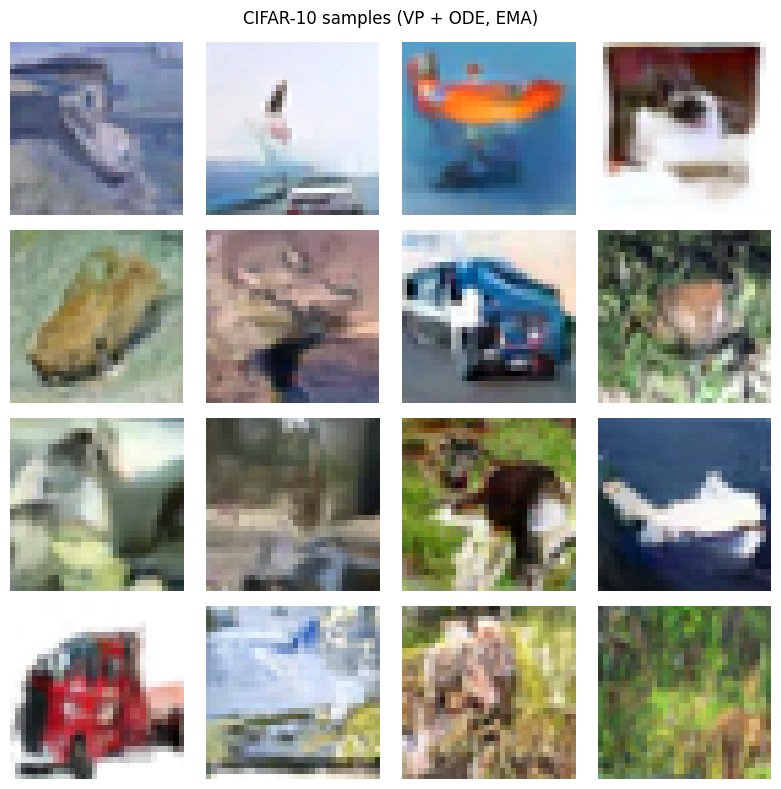

In [9]:
# ---- match training hyperparams (defaults from cifar_vp.ipynb) ----
time_dim = 32
base_channels = 128
img_channels = 3

beta_min = 0.1
beta_max = 20.0
T = 1.0

ema_weights_path = "vp_cifar_ema_weights.pth"  # from the extractor above

# ---- build ----
sde = VPSDE(beta_min=beta_min, beta_max=beta_max, T=T)

ema_model = UNetScoreCIFAR3Level(
    time_dim=time_dim,
    base_channels=base_channels,
    img_channels=img_channels,
).to(device)

ema_sd = torch.load(ema_weights_path, map_location=device)
ema_model.load_state_dict(ema_sd, strict=True)
ema_model.eval()

samples = sample_prob_flow_ode(
    ema_model, sde,
    num_steps=2000,
    batch_size=16,
    device=device,
    t_min=1e-4
)

show_cifar_grid(samples, nrow=4, title="CIFAR-10 samples (VP + ODE, EMA)")
